<a href="https://colab.research.google.com/github/kheedogg/AIR/blob/main/%5BBI-132%5D%20TM%20AIPracticeQuiz%20data%20extract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os 
os.chdir('/content/drive/MyDrive/TM/AIPracticeQuiz/')

In [4]:
# Get AWS credentials
import json
with open('../../athena_key/enuma_key.json') as f:
    aws_access = json.load(f)

In [5]:
!pip install PyAthena[Pandas]

     |████████████████████████████████| 40 kB 3.4 MB/s 
     |████████████████████████████████| 132 kB 8.5 MB/s 
     |████████████████████████████████| 8.7 MB 49.5 MB/s 
     |████████████████████████████████| 79 kB 7.9 MB/s 
     |████████████████████████████████| 138 kB 68.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [6]:
# these should work
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

In [7]:
# using cursor_class=PandasCursor makes fetching data much faster

yesterday = datetime.strftime(datetime.now() - timedelta(1), '%Y-%m-%d')
athena = connect(aws_access_key_id=aws_access['aws_access_key_id'],
             aws_secret_access_key=aws_access['aws_secret_access_key'],
             s3_staging_dir='s3://enuma-dw/',
             region_name='us-west-2',
             cursor_class=PandasCursor).cursor()

In [8]:
import pandas as pd
import sqlite3 

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
#sns.set(style="white", color_codes=True)
%matplotlib inline

In [54]:
query = f"""
SELECT distinct problemid
from dw_tmp.todomath_camp
WHERE game_mode = '0'
"""

%time tmp_df = athena.execute(query).as_pandas()
tmp_df # problemid list

CPU times: user 89.5 ms, sys: 3.57 ms, total: 93.1 ms
Wall time: 3.62 s


,problemid
0,operation_objects^7+3=?
1,operation_objects^18-2=?
2,simple_operation^3+6=?
3,operation_objects^10-9=?
4,simple_operation^3-3=?
...,...
4137,operation_vertical^67-26=?
4138,operation_vertical^23+28=?
4139,operation_vertical^500+116=?
4140,operation_vertical^91-49=?


In [49]:
query = f"""
WITH log AS (
  SELECT *
  FROM dw_tmp.todomath_camp
  WHERE game_mode = '0'
)
SELECT distinct problemid
from log
WHERE problem_level LIKE 'place%'
LIMIT 100
"""

%time tmp_df = athena.execute(query).as_pandas()
tmp_df # place problems list

CPU times: user 69 ms, sys: 3.62 ms, total: 72.6 ms
Wall time: 3.11 s


,problemid
0,operation_objects^2+3=?
1,operation_objects^5-3=?
2,simple_operation^5+5=?
3,simple_operation^10-5=?
4,adv_operation_addition^8+?=10
5,simple_operation^9+8=?
6,simple_operation^16-12=?
7,operation_vertical^26+32=?
8,simple_operation^13-6=?
9,operation_vertical^47-25=?


In [84]:
query = f"""
WITH log AS (
  SELECT *
  from  (
    SELECT accountid
    , userid
    , installid
    , game_mode
    , problemid
    , first_correct
    , final_correct
    , ROW_NUMBER() OVER(PARTITION BY userid, problemid ORDER BY game_sessionid DESC) AS rn
    -- , SPLIT_PART(problemid, '^', 2) AS problemid2
    FROM dw_tmp.todomath_camp
    WHERE game_mode = '0' 
    )
  WHERE rn=1
), prob_cnt AS (
  SELECT problemid
  , COUNT(1) AS cnt
  FROM log
  GROUP BY 1
)
SELECT *
FROM log
WHERE problemid IN (SELECT problemid FROM prob_cnt WHERE cnt>=500)
"""

%time tmp_df = athena.execute(query).as_pandas()
tmp_df

CPU times: user 10.7 s, sys: 506 ms, total: 11.2 s
Wall time: 25.4 s


,accountid,userid,installid,game_mode,problemid,first_correct,final_correct,rn
0,0156e8f0-983e-11ec-816a-55d5a856b603,82c3da02-9890-4460-802c-ba7d1cf0a94c,43bec239-0008-4e76-a4be-dbc9f18b0870,0,operation_objects^5+12=?,True,True,1
1,0156e8f0-983e-11ec-816a-55d5a856b603,82c3da02-9890-4460-802c-ba7d1cf0a94c,43bec239-0008-4e76-a4be-dbc9f18b0870,0,simple_operation^4+2=?,True,True,1
2,03088c20-5b82-11eb-be6e-ab6177d34381,1bc8e991-78a3-4a01-8d05-694c465c08ce,a25cfa5b-7c1e-4f6c-9387-94ee0a7c1b22,0,adv_operation_addition^8+?=10,True,True,1
3,03088c20-5b82-11eb-be6e-ab6177d34381,1bc8e991-78a3-4a01-8d05-694c465c08ce,a25cfa5b-7c1e-4f6c-9387-94ee0a7c1b22,0,simple_operation^16-12=?,True,True,1
4,05d74a00-dd8b-11eb-958a-1f94036a4dc1,2D4D9507-9DB6-443E-AC0E-60036838F303,d38fe101-5b69-44d8-88a5-03b14561f4f8,0,adv_operation_addition^8+?=10,True,True,1
...,...,...,...,...,...,...,...,...
899011,kakao_f7dd6090-5bb9-11eb-9da7-a97e57e896b5,AEA59F28-AD88-43B9-8116-868F8D03D3F1,72f68c31-657b-4fa4-a69e-f4b87e099de7,0,operation_objects^3-2=?,True,True,1
899012,kakao_f9b65070-27de-11eb-bf83-e79a263c4889,053f7fb8-2754-485f-a930-9efc6a03f916,4759629d-33be-4dd6-86f8-19abdb89c65c,0,adv_operation_subtraction^10-?=1,True,True,1
899013,kakao_f9b65070-27de-11eb-bf83-e79a263c4889,6405b6bb-922b-4b93-9c03-0462e1fc9302,ce54e717-0b6d-4399-9cab-7fffe2ab9854,0,operation_objects^3-2=?,True,True,1
899014,kakao_f9b65070-27de-11eb-bf83-e79a263c4889,6405b6bb-922b-4b93-9c03-0462e1fc9302,ce54e717-0b6d-4399-9cab-7fffe2ab9854,0,operation_objects^0+10=?,True,True,1


In [58]:
# tmp_df.user_cnt.describe()

count     4142.000000
mean       386.100676
std        889.757115
min         37.000000
25%         98.000000
50%        212.000000
75%        369.000000
max      24872.000000
Name: user_cnt, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


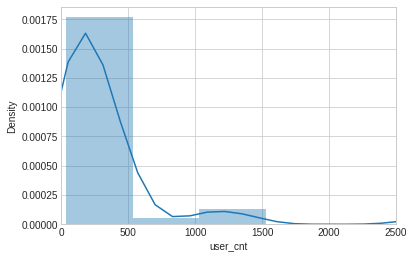

In [73]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# fig, ax = plt.subplots()
# sns.distplot(tmp_df.user_cnt, ax=ax)
# ax.set_xlim(0, 2500)
# plt.show()

In [85]:
prob_details = tmp_df.pivot_table(values='first_correct', index='userid', columns='problemid').fillna('')
# move place problems to the front
d1 = prob_details[['operation_vertical^47-25=?',
              'operation_objects^2+3=?',
              'simple_operation^9+8=?',
              'operation_vertical^26+32=?',
              'operation_objects^5-3=?',
              'adv_operation_addition^8+?=10',
              'simple_operation^10-5=?',
              'simple_operation^16-12=?',
              'simple_operation^5+5=?',
              'simple_operation^13-6=?']]
d2 = prob_details[prob_details.columns.difference(['operation_vertical^47-25=?',
              'operation_objects^2+3=?',
              'simple_operation^9+8=?',
              'operation_vertical^26+32=?',
              'operation_objects^5-3=?',
              'adv_operation_addition^8+?=10',
              'simple_operation^10-5=?',
              'simple_operation^16-12=?',
              'simple_operation^5+5=?',
              'simple_operation^13-6=?'])]
prob_details = pd.concat([d1,d2], axis=1)
prob_details

problemid,operation_vertical^47-25=?,operation_objects^2+3=?,simple_operation^9+8=?,operation_vertical^26+32=?,operation_objects^5-3=?,adv_operation_addition^8+?=10,simple_operation^10-5=?,simple_operation^16-12=?,simple_operation^5+5=?,simple_operation^13-6=?,...,simple_operation^9-0=?,simple_operation^9-1=?,simple_operation^9-2=?,simple_operation^9-3=?,simple_operation^9-4=?,simple_operation^9-5=?,simple_operation^9-6=?,simple_operation^9-7=?,simple_operation^9-8=?,simple_operation^9-9=?
userid,,,,,,,,,,,,,,,,,,,,,
0000DD70-4762-4174-8AD4-A6F9E6456806,,1.0,,,0.0,,,,,,...,1.0,,,,,,1.0,,,
000F2D81-3B78-405A-86E4-480D1E59DDE2,,1.0,,,1.0,,,,0.0,,...,,,,,,,,,,
000e48d9-7d48-4862-93c9-e8572bc94663,,1.0,0.0,,1.0,1.0,1.0,,1.0,,...,1.0,,,,,,,,,
00101af7-0fa2-4151-ad40-779f3b7f5ca1,,1.0,,,1.0,,0.0,,1.0,,...,,,,,,,,,,
0011696C-D761-44A5-A580-0AB0C2933E80,,,,,,,,,,,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffe4a202-0b80-4f00-b613-7f46b50c388b,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,,,,,,,,,,
ffeb2103-2ea6-4e93-aae9-259b3e8b29a3,,1.0,,,1.0,,,,0.0,,...,,,,,,,,,,
fff1af44-875e-4813-b426-599bece7f1d6,,,,,,,,,,,...,,,,,,,,,,


In [81]:
# prob_details.to_csv('prob_details.csv')
# prob_details.to_csv('prob_details_over500.csv')

In [35]:
# Checking data by using an example
tmp_df[tmp_df.userid == '0000DD70-4762-4174-8AD4-A6F9E6456806'][['problemid','first_correct','final_correct']]

,problemid,first_correct,final_correct
15632,simple_operation^10+30=?,True,True
31983,operation_objects^10-8=?,True,True
55085,simple_operation^8-6=?,True,True
55086,simple_operation^75+3=?,True,True
67633,operation_objects^9-7=?,True,True
...,...,...,...
1258129,operation_objects^18-12=?,True,True
1258864,simple_operation^16-15=?,True,True
1309652,simple_operation^2+0=?,True,True
1311118,operation_objects^13-8=?,True,True
